<a href="https://colab.research.google.com/github/ANSHULAGARWAL09/NER_using_LSTM/blob/master/NER_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The three common methods to approach entity extraction (and recognition)
1.Statistical models
2.Entity lists
3.Regular Expressions

Here, we will se state-of-art-statistical model .

In [1]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 747kB 46.6MB/s 


In [2]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


**Hyper-parameters Optimization**

In [0]:
# Hyperparams
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 80  # Max length of review (in words)
EMBEDDING = 40  # Dimension of word embedding vector

**Importing Dataset**

In [4]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(10)

Number of sentences:  47960
Number of words in the dataset:  35179
Tags: ['I-eve', 'B-geo', 'I-gpe', 'B-per', 'I-nat', 'B-tim', 'B-gpe', 'B-nat', 'O', 'I-org', 'B-art', 'I-art', 'I-per', 'I-tim', 'B-eve', 'I-geo', 'B-org']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


**Visualization**

To visualize the data I plotted a graph Between the number of tokens and number of samples

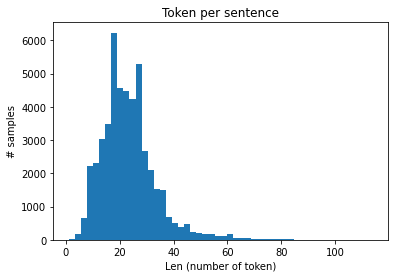

In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()

# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()


Tokens per sentence comes out as Gaussian Distribution which was expected due to central limit theorem.

In [6]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))

The word Obama is identified by the index: 27406


In [7]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))

The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 2


In [8]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [18018 19903  6601 24468 11488 11855 15580  4595  8990  5078  7046 31512
   749  5780 34811  5078 10377 19903 11515 18048 29058 16869 20904 24380
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [9]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 40)            1407240   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 80, 18)            1278      
Total params: 1,449,968
Trainable params: 1,449,968
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


**Training and Evaluation**

In [10]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38847 samples, validate on 4317 samples
Epoch 1/5
 - 31s - loss: 0.5081 - crf_viterbi_accuracy: 0.8689 - val_loss: 0.2361 - val_crf_viterbi_accuracy: 0.9536
Epoch 2/5
 - 28s - loss: 0.2043 - crf_viterbi_accuracy: 0.9546 - val_loss: 0.1501 - val_crf_viterbi_accuracy: 0.9567
Epoch 3/5
 - 30s - loss: 0.1085 - crf_viterbi_accuracy: 0.9679 - val_loss: 0.0800 - val_crf_viterbi_accuracy: 0.9775
Epoch 4/5
 - 29s - loss: 0.0641 - crf_viterbi_accuracy: 0.9822 - val_loss: 0.0546 - val_crf_viterbi_accuracy: 0.9844
Epoch 5/5
 - 29s - loss: 0.0448 - crf_viterbi_accuracy: 0.9871 - val_loss: 0.0427 - val_crf_viterbi_accuracy: 0.9875


In [0]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [12]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        41
       B-eve       0.00      0.00      0.00        45
       B-geo       0.81      0.85      0.83      4084
       B-gpe       0.89      0.92      0.90      1670
       B-nat       0.00      0.00      0.00        29
       B-org       0.67      0.59      0.63      2101
       B-per       0.82      0.70      0.76      1822
       B-tim       0.90      0.79      0.84      2206
       I-art       0.00      0.00      0.00        39
       I-eve       0.00      0.00      0.00        37
       I-geo       0.80      0.58      0.67       794
       I-gpe       0.00      0.00      0.00        16
       I-nat       0.00      0.00      0.00         8
       I-org       0.69      0.73      0.71      1826
       I-per       0.78      0.87      0.82      1773
       I-tim       0.75      0.57      0.65       646
           O       0.98      0.99      0.99     94909
         PAD       1.00    